<a href="https://colab.research.google.com/github/PhuwadolSuphapinyo/steamlit-time-series/blob/master/Prediction_Stock_Prices_on_the_SET(Lightgbm).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lightgbm regressor

In [5]:
%%capture
!pip install starfishX
!pip install mplfinance

In [4]:
import pandas as pd
import numpy as np
import starfishX as sx
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib notebook
%matplotlib inline

In [6]:
import lightgbm as lgb
from lightgbm import early_stopping
print(f'lightgbm version = {lgb.__version__}')

lightgbm version = 4.1.0


In [44]:
today = datetime.datetime.now().strftime('%Y-%m-%d')
symbol = 'KBANK'
df = sx.loadHistData_v2(symbol, start='1999-08-19', end=today)
df.reset_index(inplace=True)

Load ข้อมูลหุ้น KBANK ย้อนหลังตั้งแต่วันที่ 04/01/2000 จนถึงปัจจุบัน


In [45]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-04,44.25,44.75,44.0,44.50,28.315300,10659200
1,2000-01-05,42.25,43.00,41.5,41.75,26.565466,16305600
2,2000-01-06,42.00,42.00,40.5,40.75,25.929169,8241300
3,2000-01-07,41.25,43.00,41.0,42.75,27.201771,6058600
4,2000-01-10,43.75,44.25,42.5,42.75,27.201771,7774300
...,...,...,...,...,...,...,...
5924,2023-11-13,131.50,132.00,130.5,131.50,131.500000,6976700
5925,2023-11-14,132.00,133.00,131.5,132.00,132.000000,8217500
5926,2023-11-15,133.00,133.00,132.0,132.00,132.000000,11937900
5927,2023-11-16,132.50,132.50,131.5,132.00,132.000000,3640200


In [46]:
y_col= 'Close'

In [47]:
def date_parts(df, date_colname='Date'):
    '''create year, month, day, dayname columns'''
    df['year']=df['Date'].dt.year
    df['month']=df['Date'].dt.month
    df['day']=df['Date'].dt.day
    df['day_name']=df['Date'].dt.day_name().astype('category')

In [48]:
date_parts(df)

In [49]:
df

,Date,Open,High,Low,Close,Adj Close,Volume,year,month,day,day_name
0,2000-01-04,44.25,44.75,44.0,44.50,28.315300,10659200,2000,1,4,Tuesday
1,2000-01-05,42.25,43.00,41.5,41.75,26.565466,16305600,2000,1,5,Wednesday
2,2000-01-06,42.00,42.00,40.5,40.75,25.929169,8241300,2000,1,6,Thursday
3,2000-01-07,41.25,43.00,41.0,42.75,27.201771,6058600,2000,1,7,Friday
4,2000-01-10,43.75,44.25,42.5,42.75,27.201771,7774300,2000,1,10,Monday
...,...,...,...,...,...,...,...,...,...,...,...
5924,2023-11-13,131.50,132.00,130.5,131.50,131.500000,6976700,2023,11,13,Monday
5925,2023-11-14,132.00,133.00,131.5,132.00,132.000000,8217500,2023,11,14,Tuesday
5926,2023-11-15,133.00,133.00,132.0,132.00,132.000000,11937900,2023,11,15,Wednesday
5927,2023-11-16,132.50,132.50,131.5,132.00,132.000000,3640200,2023,11,16,Thursday


In [50]:
df = df[['Date','Open','High','Low', 'Adj Close', 'Volume', 'year', 'month', 'day', 'day_name', 'Close']]
df

,Date,Open,High,Low,Adj Close,Volume,year,month,day,day_name,Close
0,2000-01-04,44.25,44.75,44.0,28.315300,10659200,2000,1,4,Tuesday,44.50
1,2000-01-05,42.25,43.00,41.5,26.565466,16305600,2000,1,5,Wednesday,41.75
2,2000-01-06,42.00,42.00,40.5,25.929169,8241300,2000,1,6,Thursday,40.75
3,2000-01-07,41.25,43.00,41.0,27.201771,6058600,2000,1,7,Friday,42.75
4,2000-01-10,43.75,44.25,42.5,27.201771,7774300,2000,1,10,Monday,42.75
...,...,...,...,...,...,...,...,...,...,...,...
5924,2023-11-13,131.50,132.00,130.5,131.500000,6976700,2023,11,13,Monday,131.50
5925,2023-11-14,132.00,133.00,131.5,132.000000,8217500,2023,11,14,Tuesday,132.00
5926,2023-11-15,133.00,133.00,132.0,132.000000,11937900,2023,11,15,Wednesday,132.00
5927,2023-11-16,132.50,132.50,131.5,132.000000,3640200,2023,11,16,Thursday,132.00


In [51]:
df = df.set_index('Date')
df

,Open,High,Low,Adj Close,Volume,year,month,day,day_name,Close
Date,,,,,,,,,,
2000-01-04,44.25,44.75,44.0,28.315300,10659200,2000,1,4,Tuesday,44.50
2000-01-05,42.25,43.00,41.5,26.565466,16305600,2000,1,5,Wednesday,41.75
2000-01-06,42.00,42.00,40.5,25.929169,8241300,2000,1,6,Thursday,40.75
2000-01-07,41.25,43.00,41.0,27.201771,6058600,2000,1,7,Friday,42.75
2000-01-10,43.75,44.25,42.5,27.201771,7774300,2000,1,10,Monday,42.75
...,...,...,...,...,...,...,...,...,...,...
2023-11-13,131.50,132.00,130.5,131.500000,6976700,2023,11,13,Monday,131.50
2023-11-14,132.00,133.00,131.5,132.000000,8217500,2023,11,14,Tuesday,132.00
2023-11-15,133.00,133.00,132.0,132.000000,11937900,2023,11,15,Wednesday,132.00


In [52]:
df.resample('Y').mean()

<ipython-input-52-24c5ccda75f5>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.resample('Y').mean()


,Open,High,Low,Adj Close,Volume,year,month,day,Close
Date,,,,,,,,,
2000-12-31,28.075290,28.396718,27.616795,17.776440,3.112953e+06,2000.0,6.532819,15.872587,27.937259
2001-12-31,19.472989,19.775096,19.154981,12.367354,6.126891e+06,2001.0,6.498084,15.773946,19.436398
2002-12-31,25.659004,26.009578,25.254981,16.305702,6.479688e+06,2002.0,6.513410,15.704981,25.625862
2003-12-31,36.766284,37.255747,36.230843,23.399212,7.802469e+06,2003.0,6.524904,15.750958,36.773946
2004-12-31,50.301527,50.954198,49.547710,31.941828,7.232889e+06,2004.0,6.534351,15.721374,50.199427
2005-12-31,58.387755,58.981633,57.722449,37.752422,5.588964e+06,2005.0,6.575510,15.955102,58.408163
2006-12-31,65.484556,66.173745,64.713320,43.237982,4.644193e+06,2006.0,6.528958,15.833977,65.459459
2007-12-31,73.522358,74.390244,72.666667,49.814569,6.693704e+06,2007.0,6.516260,15.947154,73.528455
2008-12-31,71.566802,72.615385,70.306680,49.427258,9.551164e+06,2008.0,6.506073,15.959514,71.410931


In [53]:
feature_cols = [
          'Open',
          'High',
          'Low',
          'Adj Close',
          'Volume',
          'year',
          'month',
          'day',
          'day_name'
]

X = df[feature_cols]
y= df[y_col]

In [54]:
(80*5927)/100

4741.6

In [55]:
split_at = 4741
X_train, X_test, y_train, y_test=X[:split_at], X[split_at:], y[:split_at], y[split_at:]
valid_sets = [X_train]

In [56]:
reg = lgb.LGBMRegressor(early_stopping_rounds=200,
                        verbosity=10)

In [57]:
reg.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'early_stopping_rounds': 200,
 'verbosity': 10}

In [58]:
params ={'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
  }

reg = lgb.LGBMRegressor(**params)

In [68]:
fit_params = {'eval_set': [(X_test, y_test)]}
reg.fit(X_train, y_train, **fit_params)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 4741, number of used features: 9
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 106.422959


In [69]:
reg.__dict__

{'boosting_type': 'gbdt',
 'objective': None,
 'num_leaves': 31,
 'max_depth': -1,
 'learning_rate': 0.1,
 'n_estimators': 100,
 'subsample_for_bin': 200000,
 'min_split_gain': 0.0,
 'min_child_weight': 0.001,
 'min_child_samples': 20,
 'subsample': 1.0,
 'subsample_freq': 0,
 'colsample_bytree': 1.0,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'random_state': None,
 'n_jobs': None,
 'importance_type': 'split',
 '_Booster': <lightgbm.basic.Booster at 0x7feb0b20be80>,
 '_evals_result': {'valid_0': OrderedDict([('l2',
                [1471.5416829884248,
                 1181.34872405752,
                 953.4798945176778,
                 758.8204613168609,
                 611.820971186501,
                 493.6952764362415,
                 394.16574237742486,
                 318.2555451238326,
                 255.39807727905648,
                 207.12114566929378,
                 170.23930583206322,
                 139.3074425334844,
                 112.7392851964494,
           

In [70]:
reg.score(X_train, y_train)

0.9999268800732617

In [71]:
reg.score(X_test, y_test)

0.9368108659073652

In [79]:
y_pred = reg.predict(X_test)
y_pred

array([183.3567864 , 186.28204909, 184.49960878, ..., 142.03884849,
       141.8167463 , 142.29631565])

In [76]:
reg.predict(X_test[:50])


array([183.3567864 , 186.28204909, 184.49960878, 186.06203985,
       186.14934365, 185.85559165, 188.07682778, 187.97312914,
       187.89298483, 183.31632246, 182.39098314, 181.52650061,
       182.35911922, 182.58086136, 185.12389346, 184.06202046,
       187.43261982, 187.83109605, 190.31704631, 190.51825474,
       194.10239165, 193.63069975, 193.63031941, 193.22476432,
       198.28889978, 201.17149745, 202.38683468, 201.4797279 ,
       202.51597594, 203.61011277, 200.02841986, 196.87247029,
       198.04323164, 198.08769896, 197.67945171, 195.67891406,
       198.02858604, 196.36742132, 196.12682324, 195.60218979,
       197.88639647, 200.27621947, 199.51089388, 198.38073371,
       196.92818046, 195.4632544 , 194.54691248, 191.3040869 ,
       190.72034168, 193.7880384 ])

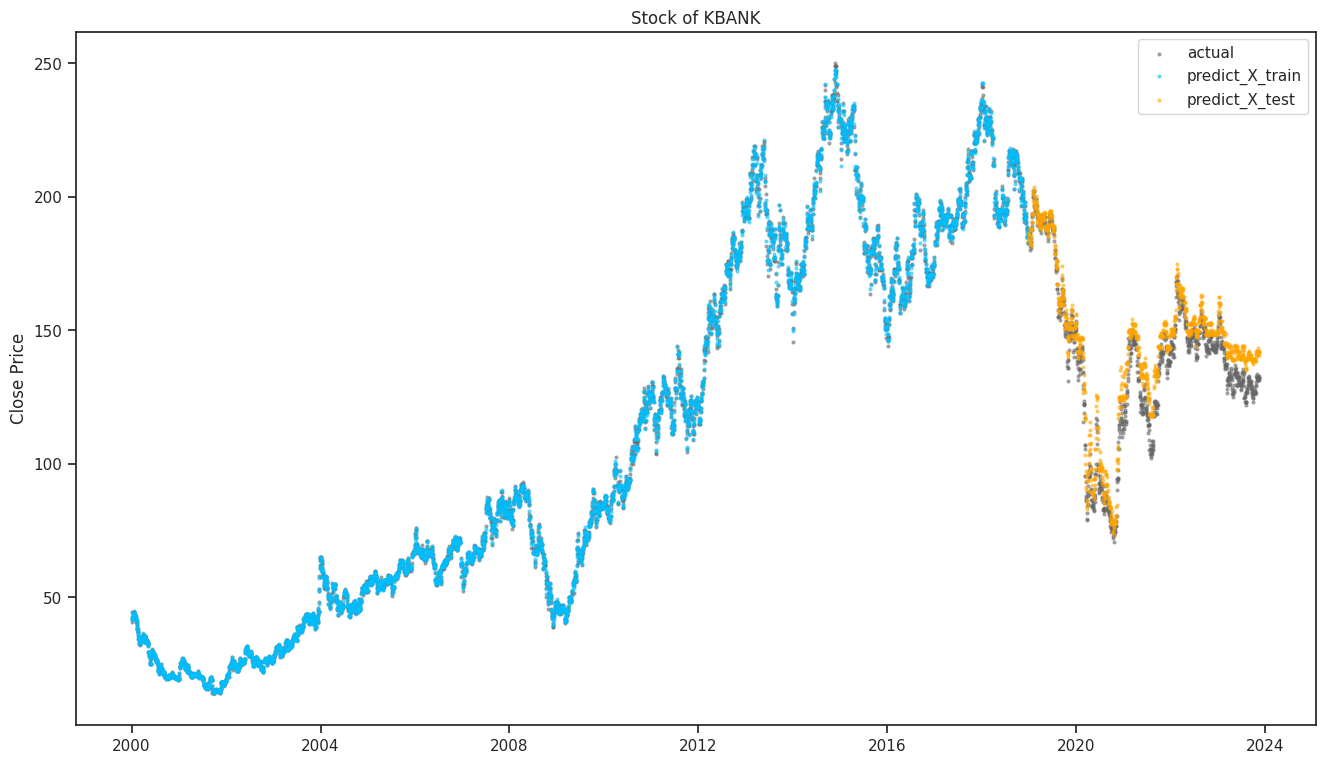

In [65]:
plt.figure(figsize=(16, 9))
plt.scatter(df.index, y, alpha=.5, s=4, label='actual', color='.4')
plt.scatter(X_train.index, reg.predict(X_train), alpha=.5, s=4, label='predict_X_train', color='deepskyblue')
plt.scatter(X_test.index, reg.predict(X_test), alpha=.5, s=4, label='predict_X_test', color='orange')
plt.ylabel('Close Price')
plt.title('Stock of KBANK')
plt.legend();

In [84]:
from sklearn.metrics import mean_squared_error, r2_score

In [86]:
# Root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((y_pred - y_test) **2)))

# R2 Score
R2=r2_score(y_test, y_pred)

#Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

print(f'Root mean squared error (RMSE): {rmse}')
print(f'R-squared (R2):                 {R2}')
print(f'Mean absolute error (MAE):      {MAE}')

Root mean squared error (RMSE): 7.317481265724239
R-squared (R2):                 0.9368108659073652
Mean absolute error (MAE):      53.545532074225214
